Prior meeting: Tues 3/7/23

Next meeting: [fill in]

Goals:
- Get ready for LPSC
---

---
# 0. Setup
---

---
## Add path to source

In [1]:
def getPath(*args):
    """Join all arguments into a single path. Use 'current' as a stand in for path to current file."""
    import os
    args = [os.getcwd() if arg == 'current' else arg for arg in args]
    return os.path.abspath(os.path.join(*args))

    
def path_addSrc(fullpath_src = None, relpath_src = None, parent = False, verbose = False):
    """
    Add directory "src/" to path.
        
    PARAMETERS:
        fullpath_src : string
            Path to source from root.
        relpath_src : string
            Path to source from directory of current file.
        parent : boolean
            Use parent folder as source
        verbose : boolean
            Prints source directory path.
    
    RETURN:
        path_src : string
            Path to source from root.
    """
    
    import sys
    import os

    if fullpath_src:
        path_src = getPath(fullpath_src)
    elif relpath_src:
        path_src = getPath('current', relpath_src)
    elif parent:
        path_src = getPath('current', '..')
        
    if verbose: print("Path to source: " + path_src)
    
    sys.path.append(path_src)
    return path_src


path_src = path_addSrc(parent=True, verbose=True)

Path to source: C:\Users\zk117\Documents\01.Research\Mars_Magnetics__uptodate\code\05_mag_src_map\src


---
## Download data
All data available here: https://drive.google.com/drive/u/0/folders/1D8oWu05X83Xa8dKB1C_SUutBNvbJUt4n

In [26]:
from lib.DataDownloader import DataDownloader as dd
dd.download_folder(path_src=path_src, url="https://drive.google.com/drive/u/0/folders/1D8oWu05X83Xa8dKB1C_SUutBNvbJUt4n", overwrite=True)

The provided `path_src` parameter doesn't contain "home". On Linux systems, this means you might be deleting important directories. If you proceed, `path_src/data/` will be deleted. Make sure you have provided the correct path. 

Would you like to proceed? [y/n]  y



Data folder contents: 
	craters
	crustal_heat_flow
	crustal_thickness
	GRS
	magnetization_depth
	mvn_mag
	README.txt


---
## Import crater data

In [3]:
from lib.Craters import Craters as CraterClass
Craters = CraterClass()

path = getPath(path_src, 'data', 'craters', 'Catalog_Mars_Release_2020_1kmPlus_FullMorphData.csv')
Craters.loadData(path, minDiam=70, maxDiam=1000)

---
## Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math

---
---
# 1. Crustal Thickness
---

---
## 1.1. Description
[excerpt from `src/data/crustal_thickness/README.txt`]

SOURCE:
- Data is generated by the "InSight Crustal Thickness Archive" code by Mark A. Wieczorek: 
    - link: https://zenodo.org/record/6477509 (doi: 10.5281/zenodo.6477509)
- Code is supplemental to the manuscript:
    - Wieczorek, M. A., et al., InSight constraints on the global character of the Martian crust, Journal of Geophysical Research: Planets, 2022.

PARAMETERS:
- We use `make-grids.py` with parameters:
    - Reference interior model = DWThot
        - Emailed Gong about what he's using but he hasn't gotten back to me, gonna try talking to Weiczoreck at LPSC
    - Seismic thickness at InSight landing site (km) = 30
    - rho_north (kg/m3) = 2900
    - rho_south (kg/m3) = 2900
    - Grid spacing in degrees = 0.1 (see file name)

---
## 1.2. Load data

In [5]:
from lib.Crust import Crust as CrustClass

Crust = CrustClass()
Crust.loadData(path_src, spacing=0.1)

---
## 1.3. Example 1: Create (*fully interpolated*) crustal thickness map
i.e. all crustal thickness data points come from bilinear interpolation between the 4 points closest to the coordinate in question

In [6]:
# dat = []

# for lat in np.arange(-90,90,1):
#     newline = []
#     for clon in np.arange(0,360,1):
#         lon = Craters.clon2lon(clon)
#         x = Crust.getThickness(lon, lat)
#         newline.append(x)
#     dat.append(newline)

    
# # dat = np.asarray(dat)
# # dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

# fig = plt.figure(figsize=(12,10))
# ax = plt.axes()
# im = ax.imshow(dat[::-1], cmap="jet")

# cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
# plt.colorbar(im, cax=cax)

We verify this by comparing it against the crustal thickness maps created by (1) [Gong & Wieczorek 2021](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020JE006690), and (2) Wieczorek's crustal thickness map generator library [ctplanet](https://github.com/MarkWieczorek/ctplanet):

<img src="https://i.imgur.com/ZOoYSBo.png" width=800 />

<img src="https://i.imgur.com/YE75rQS.png" width=800 />


---
## 1.4. Example 2: Plot crustal thickness around Henry Crater

In [7]:
# thiscrater = Craters.getByName('Henry')
# radius_th = Craters.km2theta(thiscrater['diam']/2)
# scaling = 2

# dat = []

# for lat in np.arange(thiscrater['lat']-radius_th*scaling,thiscrater['lat']+radius_th*scaling,0.05):
#     newline = []
#     for lon in np.arange(thiscrater['lon']-radius_th*scaling,thiscrater['lon']+radius_th*scaling,0.05):
#         x = Crust.getThickness(lon, lat)
#         newline.append(x)
#     dat.append(newline)

    
# # dat = np.asarray(dat)
# # dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

# fig = plt.figure(figsize=(10,7))
# ax = plt.axes()
# im = ax.imshow(dat[::-1], cmap="jet")

# cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
# plt.colorbar(im, cax=cax)

---
## 1.5. Example 3: Get average crustal thickness around Henry crater

In [8]:
henry = Craters.getByName('Henry')
radius_th = Craters.km2theta(henry['diam']/2)
Crust.getAvgThickness(henry['lon'], henry['lat'], radius_th)

43.66251168960871

---
## 1.6. Some more cool plots

### Lyot

In [9]:
# thiscrater = Craters.getByName('Lyot')
# radius_th = Craters.km2theta(thiscrater['diam']/2)
# scaling = 3

# dat = []

# for lat in np.arange(thiscrater['lat']-radius_th*scaling,thiscrater['lat']+radius_th*scaling,0.1):
#     newline = []
#     for lon in np.arange(thiscrater['lon']-radius_th*scaling,thiscrater['lon']+radius_th*scaling,0.1):
#         x = Crust.getThickness(lon, lat)
#         newline.append(x)
#     dat.append(newline)

    
# # dat = np.asarray(dat)
# # dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

# fig = plt.figure(figsize=(10,7))
# ax = plt.axes()
# im = ax.imshow(dat[::-1], cmap="jet")

# cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
# plt.colorbar(im, cax=cax)

### Newton

In [10]:
# thiscrater = Craters.getByName('Newton')
# radius_th = Craters.km2theta(thiscrater['diam']/2)
# scaling = 3

# dat = []

# for lat in np.arange(thiscrater['lat']-radius_th*scaling,thiscrater['lat']+radius_th*scaling,0.1):
#     newline = []
#     for lon in np.arange(thiscrater['lon']-radius_th*scaling,thiscrater['lon']+radius_th*scaling,0.1):
#         x = Crust.getThickness(lon, lat)
#         newline.append(x)
#     dat.append(newline)

    
# # dat = np.asarray(dat)
# # dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

# fig = plt.figure(figsize=(10,7))
# ax = plt.axes()
# im = ax.imshow(dat[::-1], cmap="jet")

# cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
# plt.colorbar(im, cax=cax)

### Tikhonravov

In [11]:
# thiscrater = Craters.getByName("Tikhonravov")
# radius_th = Craters.km2theta(thiscrater['diam']/2)
# scaling = 3

# dat = []

# for lat in np.arange(thiscrater['lat']-radius_th*scaling,thiscrater['lat']+radius_th*scaling,0.1):
#     newline = []
#     for lon in np.arange(thiscrater['lon']-radius_th*scaling,thiscrater['lon']+radius_th*scaling,0.1):
#         x = Crust.getThickness(lon, lat)
#         newline.append(x)
#     dat.append(newline)

    
# # dat = np.asarray(dat)
# # dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

# fig = plt.figure(figsize=(10,7))
# ax = plt.axes()
# im = ax.imshow(dat[::-1], cmap="jet")

# cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
# plt.colorbar(im, cax=cax)

### Gusev

In [12]:
# thiscrater = Craters.getByName("Gusev")
# radius_th = Craters.km2theta(thiscrater['diam']/2)
# scaling = 3

# dat = []

# for lat in np.arange(thiscrater['lat']-radius_th*scaling,thiscrater['lat']+radius_th*scaling,0.1):
#     newline = []
#     for lon in np.arange(thiscrater['lon']-radius_th*scaling,thiscrater['lon']+radius_th*scaling,0.1):
#         x = Crust.getThickness(lon, lat)
#         newline.append(x)
#     dat.append(newline)

    
# # dat = np.asarray(dat)
# # dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

# fig = plt.figure(figsize=(10,7))
# ax = plt.axes()
# im = ax.imshow(dat[::-1], cmap="jet")

# cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
# plt.colorbar(im, cax=cax)

---
---
# 2. Heat Flow
---

---
## 2.1. Description from paper

[10] The final term in equation 1 is $H( \theta ,\phi ,t)$, or heat production per unit mass, whose calculation is more involved as a function of position and time. The lithosphere of Mars contains certain radioactive isotopes $^{235}\text{U}$, $^{238}\text{U}$, $^{232}\text{Th}$, and $^{40}\text{K}$ which produce upward-flowing heat as they decay over time. This accounts for the majority of conductive heat loss to the surface for both Mars and Earth. The equation for $H$ is given by
\begin{equation}
H( \theta ,\phi ,t) =\sum _{X} f_{X} \cdot C_{X}( \theta ,\phi ) \cdot H_{X} \cdot \left(\frac{t\cdot \ln 2}{\tau _{X}}\right) ,
\end{equation}
for $X\in \left\{^{235}\text{U} ,^{238}\text{U} ,^{232}\text{Th} ,^{40}\text{K}\right\}$, where $f_{X}$ is the isotopic fraction of element $X$; $H_{X}$ is the heat release rate constant of element $X$; and $\tau _{X}$ is the half-life of element $X$. All three of these values are well-defined constants discussed in numerous prior works \cite{temp_id_992458856131005, turcotte2014schubert, temp_id_9542413773852181}. The first dependent variable in equation 2 is $t$, which is how long ago we wish to calculate $H$ relative to present day (this is necessary because radioactive heat-producing elements will decrease in abundance from their initial concentrations over time as they decay). This $t$ is taken to be the previously determined time of formation of a crater. 



[11] The second dependent quantity in equation 2 is $C_{X}( \theta ,\phi )$, which represents the concentration by mass of element $X$ at some position. To get this value, we used $5^\circ \times 5^\circ $ chemical abundance maps of the Martian shallow subsurface derived from spectroscopy by the Mars Odyssey Gamma Ray Spectrometer (GRS) Suite \cite{temp_id_17328796999934304}. Specifically, we extract near-surface elemental concentrations of $\text{K}$ and $\text{Th}$ at the four "pixels" closest to the crater, and use weighted bilinear interpolation to estimate the concentrations at the exact coordinates of the crater. The elemental concentration of $\text{U}$ can then be calculated using a cosmochemically constant $\text{Th} /\text{U}$ mass ratio of $3.8$. At this point, it's important to note that the GRS chemical maps only represent the top tens of centimeters of Martian surface, and are therefore heavily influenced by near-surface regolith, ice, and dust deposits. However, previous studies provide strong reasons in defense of vertically homogeneous distribution of these heat producing elements given certain adjustments \cite{temp_id_17328796999934304, temp_id_9195588768017229}. To make these $\text{K} ,\text{Th} ,$ and $\text{U}$ measurements accurately represent the bulk chemistry of the entire Martian upper lithosphere, we must renormalize our values to a volatile-free basis. This is done by using the same methods and data suite to extract near-surface elemental concentrations of $\text{Cl} ,\text{H}_{2}\text{O} ,$ and $\text{S}$ at the desired coordinate, summing these to find the net concentration by mass of volatiles denoted as $V$, and then multiplying the $\text{K} ,\text{Th} ,$ and $\text{U}$ measurements by $\frac{1}{1-V}$ \ each. We note that at high latitudes, water ice saturating regolith pore space overwhelms the signatures of other elements in gamma spectra, preventing GRS instruments from collecting meaningful data. 

---
## 2.2 GRS concentrations (*fully interpolated*)

In [13]:
from lib.GRS import GRS as GRSClass

GRS = GRSClass(getPath(path_src, "data/GRS/"))
GRS.loadData()

### Potassium

In [14]:
# dat = []

# for lat in np.arange(-75,75,1):
#     newline = []
#     for lon in np.arange(-180,180,1):
#         x = GRS.getConcentration(lon, lat, 'k', normalized=False)
#         newline.append(x)
#     dat.append(newline)

    
# dat = np.asarray(dat)
# dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

# fig = plt.figure(figsize=(10,7))
# ax = plt.axes()
# im = ax.imshow(dat[::-1], cmap="jet")

# cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
# plt.colorbar(im, cax=cax)

Comparison with [GRS maps](https://pds-geosciences.wustl.edu/ody/ody-m-grs-5-elements-v1/odgm_xxxx/browse/browse.htm).

<img src="https://pds-geosciences.wustl.edu/ody/ody-m-grs-5-elements-v1/odgm_xxxx/browse/k_conc_map.jpg" width=800 />

### Thorium

In [15]:
# dat = []

# for lat in np.arange(-75,75,1):
#     newline = []
#     for lon in np.arange(-180,180,1):
#         x = GRS.getConcentration(lon, lat, 'th', normalized=False)
#         newline.append(x)
#     dat.append(newline)

    
# dat = np.asarray(dat)
# dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

# fig = plt.figure(figsize=(10,7))
# ax = plt.axes()
# im = ax.imshow(dat[::-1], cmap="jet")

# cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
# plt.colorbar(im, cax=cax)

Comparison with [GRS maps](https://pds-geosciences.wustl.edu/ody/ody-m-grs-5-elements-v1/odgm_xxxx/browse/browse.htm).

<img src="https://pds-geosciences.wustl.edu/ody/ody-m-grs-5-elements-v1/odgm_xxxx/browse/th_conc_map.jpg" width=800 />

--- 
## 2.3. Crustal heat production map
Calculate heat production rate in lithosphere [W/kg?] at a specific coordinate/time due to decay of radiogenic heat producing elements (U238, U235, Th232, K40).
\begin{equation}
H( \theta ,\phi ,t) =\sum _{X} f_{X} \cdot C_{X}( \theta ,\phi ) \cdot H_{X} \cdot \left(\frac{t\cdot \ln 2}{\tau _{X}}\right) ,
\end{equation}
for $X\in \left\{^{235}\text{U} ,^{238}\text{U} ,^{232}\text{Th} ,^{40}\text{K}\right\}$

**NOTE: We are using t = 3.5 Ga**

In [16]:
from lib.HeatCalculator import HeatCalculator as HeatCalculatorClass

HeatCalculator = HeatCalculatorClass(GRS, Crust)

### WITHOUT volatile normalization

In [17]:
# dat = []

# for lat in np.arange(-75,75,2):
#     newline = []
#     for clon in np.arange(0,360,2):
#         lon = Craters.clon2lon(clon)
#         H = HeatCalculator.calc_H(lon, lat, t=3.5e9, volatile_adjusted=False)
#         x = H
#         newline.append(x)
#     dat.append(newline)

    
# dat = np.asarray(dat)
# dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

# fig = plt.figure(figsize=(12,10))
# ax = plt.axes()
# im = ax.imshow(dat[::-1], cmap="jet")

# cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
# plt.colorbar(im, cax=cax)

### WITH volatile normalization

In [18]:
# dat = []

# for lat in np.arange(-75,75,2):
#     newline = []
#     for clon in np.arange(0,360,2):
#         lon = Craters.clon2lon(clon)
#         H = HeatCalculator.calc_H(lon, lat, t=3.5e9, volatile_adjusted=True)
#         x = H
#         newline.append(x)
#     dat.append(newline)

    
# dat = np.asarray(dat)
# dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

# fig = plt.figure(figsize=(12,10))
# ax = plt.axes()
# im = ax.imshow(dat[::-1], cmap="jet")

# cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
# plt.colorbar(im, cax=cax)

---
## 2.4. Crustal heat flow map

Watts/m^2, calculated with $\rho \cdot H(\theta,\phi,t) \cdot z_{\text{crust}}(\theta, \phi)$

- (we assume constant $\rho = 2900$)

In [19]:
# dat = []

# for lat in np.arange(-75,75,2):
#     newline = []
#     for clon in np.arange(0,360,2):
#         lon = Craters.clon2lon(clon)
        
#         rho = Crust.getDensity()
#         H = HeatCalculator.calc_H(lon, lat, t=3.5e9, volatile_adjusted=True)
#         z_crust = Crust.getThickness(lon, lat) * 1000
        
#         x = (rho * H * z_crust)*1000 # convert to mW!!!
#         newline.append(x)
#     dat.append(newline)

    
# dat = np.asarray(dat)
# # dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)
# dat = np.ma.masked_where((dat < 0), dat)

# fig = plt.figure(figsize=(12,10))
# ax = plt.axes()
# im = ax.imshow(dat[::-1], cmap="jet")

# cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
# plt.colorbar(im, cax=cax)

### Comparison with Luju's map

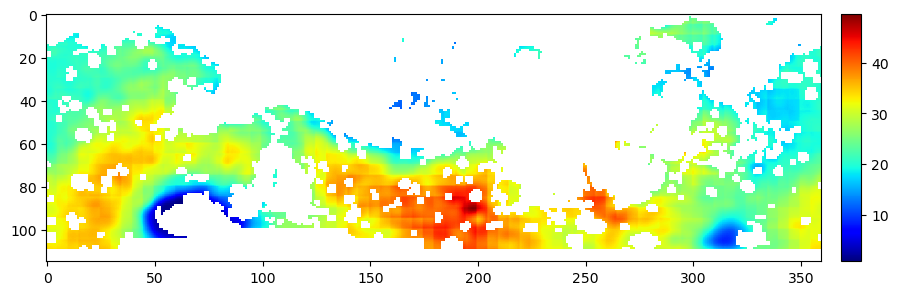

In [20]:
import scipy.io as sio

# matfile = sio.loadmat("HcrGRS_Hm30.mat")
# H_cr = matfile['hf_m30']

matfile = sio.loadmat(getPath(path_src, 'data', 'crustal_heat_flow', 'HcrGRS_Hm0.mat'))
H_cr = matfile['nhf']


fig = plt.figure(figsize=(10,7))
ax = plt.axes()
im = ax.imshow(H_cr[35:150], cmap="jet")

cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)

---
# 3. Curie Depths

In [21]:
from lib.HeatCalculator import HeatCalculator as HeatCalculatorClass

HeatCalculator = HeatCalculatorClass(GRS, Crust)

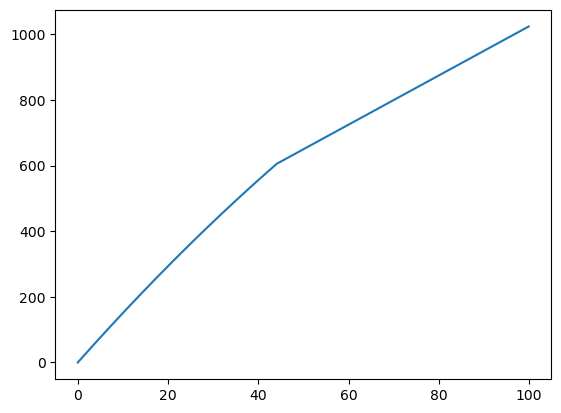

In [23]:
# thiscrater = Craters.getByName('Henry')

# depths_km, temps_C = HeatCalculator.calc_TempDepthProfile(thiscrater['lon'], thiscrater['lat'], thiscrater['age'], 30, 100)

# plt.plot(depths_km, temps_C)

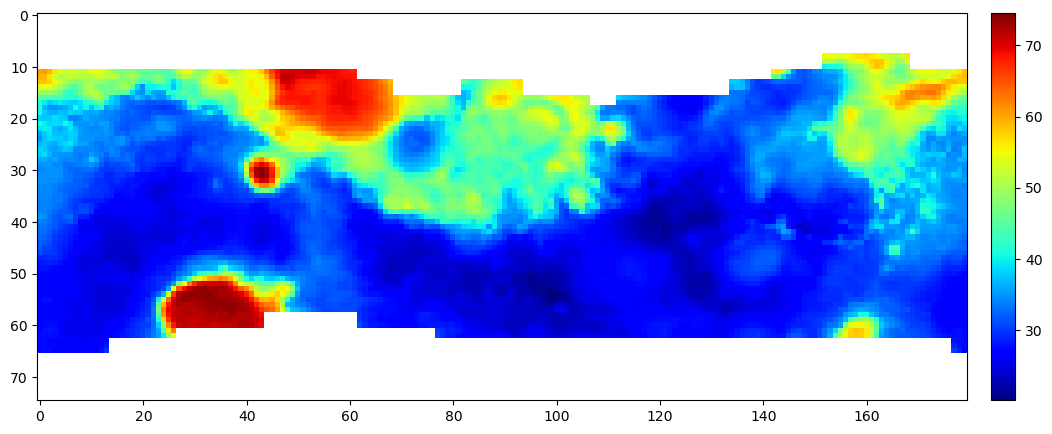

In [24]:
# dat = []

# for lat in np.arange(-75,75,2):
#     newline = []
#     for clon in np.arange(0,360,2):
#         lon = Craters.clon2lon(clon)
#         x = HeatCalculator.calc_CurieDepths(lon, lat, t=3.5e9, q_b_mW=30, curie_temps=580, volatile_adjusted=True)
#         newline.append(x)
#     dat.append(newline)

    
# dat = np.asarray(dat)
# dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

# fig = plt.figure(figsize=(12,10))
# ax = plt.axes()
# im = ax.imshow(dat[::-1], cmap="jet")

# cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
# plt.colorbar(im, cax=cax)

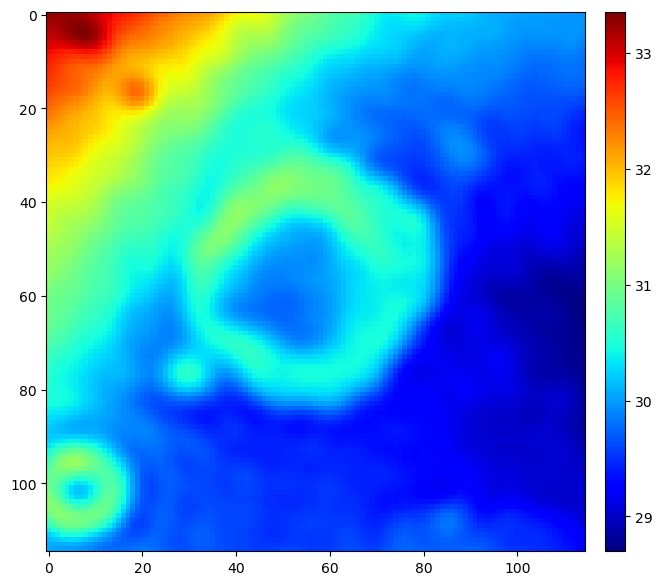

In [25]:
# thiscrater = Craters.getByName('Henry')
# radius_th = Craters.km2theta(thiscrater['diam']/2)
# scaling = 2

# dat = []

# for lat in np.arange(thiscrater['lat']-radius_th*scaling,thiscrater['lat']+radius_th*scaling,0.05):
#     newline = []
#     for lon in np.arange(thiscrater['lon']-radius_th*scaling,thiscrater['lon']+radius_th*scaling,0.05):
#         x = HeatCalculator.calc_CurieDepths(lon, lat, t=3.5e9, q_b_mW=30, curie_temps=580, volatile_adjusted=True)
#         newline.append(x)
#     dat.append(newline)

    
# # dat = np.asarray(dat)
# # dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

# fig = plt.figure(figsize=(10,7))
# ax = plt.axes()
# im = ax.imshow(dat[::-1], cmap="jet")

# cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
# plt.colorbar(im, cax=cax)

---
# 4. Impact Demag

In [ ]:
def calc_P(diameter_km, r_km, z_km):
    
    ## unit conversions
    diameter_m = diameter_km * 1000
    r_m = r_km * 1000 # horizontal distance from impact site
    z_m = z_km * 1000 # depth from floor of crater (?)
    
    
    ## start complicated math shit -- NOTE THAT EVERYTHING IS IN SI, I.E. METERS NOT KILOMETERS!!!
    
    diam_obs = diameter_m # observed crater diameter
    diam_star = 7 * 1000 # transition diameter from simple to complex crater, assumed 7km for mars
    diam_trans = 0.7576 * (diam_obs ** 0.921) * (diam_star ** 0.079)
    # print(diam_trans / 1000)
    
    v_proj = 10 * 1000 # impact velocity, varies from 8-12 km/s, assumed 10 km/s
    g = 3.721 # surface gravity
    E = ((diam_trans * v_proj**0.09 * g**0.22)/(0.2212)) ** (1/0.26) # energy of impactor
    
    rho = 2900 # density of impactor, assumed 2900 kg/m^3 for basaltic
    r_proj = ((3 * E)/(2 * math.pi * rho * v_proj**2))**(1/3) # radius of impactor, assumed to be spherical basaltic projectile
    
    R_0 = 0.75 * r_proj # radius of isobaric core, ~70% of projectile radius
    
    C_basalt = 3.5 * 1000 # bulk speed of sound in material, assumed 3.5 km/s for kinosaki basalt
    S_basalt = 1.5 # shock parameter of material, assumed 1.5 for kinosaki basalt
    
    P_0 = 0.25 * rho * v_proj * (2*C_basalt + S_basalt*v_proj) # isobaric pressure (within isobaric core)
    
    R_direct = math.sqrt( (z_m - R_0)**2 + r_m**2 ) # distance travelled by direct pressure waves
    R_reflect = math.sqrt( (z_m + R_0)**2 + r_m**2 ) # distance travelled by reflected pressure waves
    
    tau = (R_reflect - R_direct) / C_basalt # time delay between arrival of initial and reflected pressure waves
    tau_rise = r_proj / v_proj # time rise (?)
    
    def naive_P(this_r):
        if (this_r <= R_0):
            P = P_0
        else:        
            n = 1.87 # exponential decay constant, assumed invariant with distance from impact
            # P = P_0 * ((this_r / R_0) ** -n) # for some reason this blows up ????? so i use the shahnas equation instead lol
            P = rho * (0.5*v_proj) * (C_basalt + S_basalt * (0.5*v_proj) * (R_0/this_r)**n ) * (R_0/this_r)**n
        return P
    
    if (tau > tau_rise):
        P_eff = naive_P(R_direct)
    else: # reduced peak pressure due to interference of waves
        P_eff = naive_P(R_direct) - naive_P(R_reflect) * (1 - (tau / tau_rise)) 
        
    P_eff = P_eff * 1e-9 # adjust to units of gigapascals

    return P_eff

---
# 5. Mag Depth

In [41]:
dat = getPath(path_src,'data','magnetization_depth','20_17_8_134_150.dat')
dat = np.loadtxt(dat)
dat.shape

(412, 6)

In [42]:
dat = dat[:,[0,1,3]]
dat.shape

(412, 3)